In [50]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from clusters_htc import batch_clusters
from clusters_ising import batch_clusters_ising

# HTC model example: clusters for SM RSN disconnected in  Hagmann conn. 

In [34]:
# load simulation output
data = np.load("sims/hagmann_disconnected_rsn_4/output.npz")
print("HTC simulation ouput file contains two objects ", data.files)

HTC simulation ouput file contains two objects  ['activation_matrix', 'Ts']


In [35]:
# read thresholds and activity matrix
Ts = data['Ts']
act = data['activation_matrix']

# create 'rsn' and 'the rest' masks on the full adj. matrix
connectome = np.loadtxt("sims/hagmann_disconnected_rsn_4/connection_matrix.dat")

roi_labels = np.load("hagmann_connectome.npz")['roi_lbs']

rsn_mask = roi_labels == 4.0
rest_mask = roi_labels != 4.0

adj_full = connectome
adj_rsn = connectome[rsn_mask][::,rsn_mask]
adj_rest = connectome[rest_mask][::,rest_mask]

act_rsn = act[:, rsn_mask]
act_rest = act[:, rest_mask]

In [36]:
# compute clusters (in batches for all Ts)

clusters_rsn = batch_clusters(act_rsn, adj_rsn)
clusters_rest = batch_clusters(act_rest, adj_rest)
clusters_full = batch_clusters(act, adj_full)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:06<00:00,  4.21s/it]


In [37]:
# clusters are averaged, by default computes 10 largest clusters
print(Ts.shape, clusters_rsn.shape)

(30,) (30, 10)


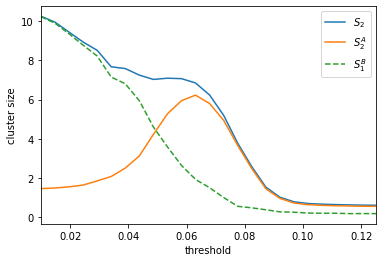

In [43]:
# Plot clusters analogously to Fig.8:
#     S2 for the total system
#     S2 for "the rest"
#     S1 for the RSN

plt.plot(Ts, clusters_full[:,1], "C0-", label='$S_2$')
plt.plot(Ts, clusters_rest[:,1], "C1-", label='$S_2^A$')
plt.plot(Ts, clusters_rsn[:,0], "C2--", label='$S_1^B$')
plt.xlim(0.01,0.125)
plt.xlabel("threshold")
plt.ylabel("cluster size")

plt.legend();

In [48]:
# save the results

def dict_result(cl, ts):
    data = dict()
    data['Ts'] = ts
    data['clusters'] = cl
    return data

clusters_rsn_dict = dict_result(clusters_rsn, Ts)
clusters_rest_dict = dict_result(clusters_rest, Ts)
clusters_full_dict = dict_result(clusters_full, Ts)

dir_name = 'analyses/hagmann_disconnected_rsn_4/'
np.savez_compressed(os.path.join(dir_name, "clusters_rsn_data.npz"), **clusters_rsn_dict)
np.savez_compressed(os.path.join(dir_name, "clusters_rest_data.npz"), **clusters_rest_dict)
np.savez_compressed(os.path.join(dir_name, "clusters_full_data.npz"), **clusters_full_dict)


# Ising example:  micro 16x16 system sliced into 80 vs 176 spins

In [51]:
data = np.load("sims/ising_sliced_16x16/output.npz")
Ts = data["Ts"]
activity = data['activation_matrix']

In [54]:
connectivity = np.load("connection_matrices/ising_sliced_16x16_frac=1.0_nonperiodic.npz", allow_pickle=True)
L = 16
mask_a = connectivity["subsystems"].reshape((L,L))
mask_b = 1-mask_a

In [57]:
clusters_a = batch_clusters_ising(activity, mask_a, n_clusters=50)
clusters_b = batch_clusters_ising(activity, mask_b, n_clusters=50)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:30<00:00,  1.52it/s]


In [60]:
# put together results of subsystems to get the clustrs in the full system
# ATTENTION: this works only for fully disconnected subsystems!
clusters_full = np.concatenate((clusters_a, clusters_b), axis=2)
clusters_full = np.sort(clusters_full, axis=2)[:, :, ::-1]

In [63]:
# clusters are NOT averaged, by default computes 10 largest clusters
print(Ts.shape, clusters_a.shape)

(46,) (46, 5000, 50)


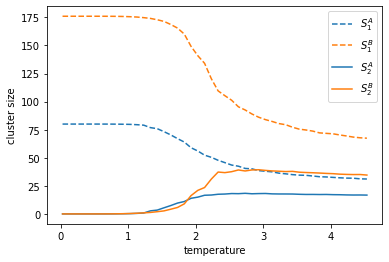

In [69]:
# plot clusters vs. temperature like in Fig 2 (small system size effect clearly visible!)

plt.plot(Ts, clusters_a.mean(axis=1)[:,0],"C0--", label='$S_1^A$')
plt.plot(Ts, clusters_b.mean(axis=1)[:,0], "C1--", label='$S_1^B$')

plt.plot(Ts, clusters_a.mean(axis=1)[:,1], "C0-", label='$S_2^A$')
plt.plot(Ts, clusters_b.mean(axis=1)[:,1], "C1-", label='$S_2^B$')

plt.xlabel('temperature')
plt.ylabel('cluster size')
plt.legend();